# HMM POS TAGGING

In [ ]:
import nltk
import numpy as np
import math
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
start= '^'
end= '$'
tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')
result=[]
for i in range(len(tagged_sentences)):
    temp=[]
    sentence = tagged_sentences[i]
    temp.append((start,start))
    for word,tag in sentence:
        temp.append((word.lower(),tag))
    temp.append((end,end))
    result.append(temp)

tagged_sentences = result

In [ ]:
def Training(sentences):
    list_of_all_tuples = []
    for sentence in sentences:
        for word,tag in sentence:
            list_of_all_tuples.append((word,tag))
    POS_tag_counts = Counter(tag for word,tag in list_of_all_tuples)
    word_pos_tags = defaultdict(Counter)
    for word,pos_tag in list_of_all_tuples:
        word_pos_tags[word][pos_tag]+=1
    Tag_transition_count = defaultdict(Counter)
    for sentence in sentences:
        for i in range(len(sentence)-1):
            Tag_transition_count[sentence[i][1]][sentence[i+1][1]]+=1

    return POS_tag_counts,word_pos_tags,Tag_transition_count

In [ ]:
def transition_probability(tag1,tag2,POS_tag_counts,Tag_transition_count):
    tag1_tag2 = Tag_transition_count[tag1][tag2]
    tag1_total = POS_tag_counts[tag1]
    res = (tag1_tag2) / (tag1_total)
    if(res==0):
        res = 10**-9
    return res

In [ ]:
def lexical_probability(word,tag,POS_tag_counts,word_pos_tags):
    word_tag = word_pos_tags[word][tag]
    tag_total = POS_tag_counts[tag]
    res = (word_tag+1)/(tag_total+len(word_pos_tags))
    return res

In [ ]:
def Viterbi_Algorithm(untagged_sentence,POS_tag_counts,word_pos_tags,Tag_transition_count):
    n = len(untagged_sentence)
    prev = defaultdict(Counter)
    curr = defaultdict(Counter)
    parent = defaultdict(Counter)
    for tag in POS_tag_counts:
        prev[tag] = 0.0
    prev[start]=0.0
    parent[0][start] = 0

    for i in range(1,n-1):
        word = untagged_sentence[i]
        for tag in POS_tag_counts:
            curr[tag] = 1.0
            for prev_tag in POS_tag_counts:
                temp = prev[prev_tag] + math.log(lexical_probability(word,tag,POS_tag_counts,word_pos_tags)) + math.log(transition_probability(prev_tag,tag,POS_tag_counts,Tag_transition_count))
                if curr[tag]==1.0 or temp>curr[tag]:
                    curr[tag] = temp
                    parent[i][tag] = prev_tag
        for tag in POS_tag_counts:
            prev[tag] = curr[tag]

    final_tags = ['$' for i in range(n)]
    for tag in POS_tag_counts:
        if curr[tag] > curr[final_tags[n-2]]:
            final_tags[n-2] = tag
    for i in range(n-3,0,-1):
        final_tags[i] = parent[i+1][final_tags[i+1]]
    final_tags[0] = start
    return final_tags

In [ ]:
Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count = defaultdict(Counter), defaultdict(Counter), defaultdict(Counter)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tagged_sentences = np.array(tagged_sentences,dtype='object')
y_pred_list = []
y_true_list = []
for fold, (train, test) in enumerate(kfold.split(tagged_sentences)):
    train_sentences = tagged_sentences[train]
    test_sentences = tagged_sentences[test]
    POS_tag_counts,word_pos_tags,Tag_transition_count = Training(train_sentences)
    if(fold==3):
        Last_POS_tag_counts = POS_tag_counts
        Last_word_pos_tags = word_pos_tags
        Last_Tag_transition_count = Tag_transition_count
    y_pred = []
    y_true = []

    for sentence in test_sentences:
        untagged_sentence = [word for word,tag in sentence]
        prediction = Viterbi_Algorithm(untagged_sentence,POS_tag_counts,word_pos_tags,Tag_transition_count)
        for i in range(1,len(prediction)-1):
            y_pred.append(prediction[i])
            y_true.append(sentence[i][1])

    y_pred_list.append(np.array(y_pred))
    y_true_list.append(np.array(y_true))
    accuracy = accuracy_score(y_true_list[-1],y_pred_list[-1],normalize=True)
    print(f'Accuracy for Fold {fold + 1} : {accuracy}')

Accuracy for Fold 1 : 0.9385365979581037
Accuracy for Fold 2 : 0.9385506671210481
Accuracy for Fold 3 : 0.9381574135817075
Accuracy for Fold 4 : 0.9390884962593302
Accuracy for Fold 5 : 0.9382870068593975


In [ ]:
def sentence_checking(untagged_sentence,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count):
    untagged_sentence = untagged_sentence.lower()
    sentence_list = untagged_sentence.split()
    sentence_list = ['^'] + sentence_list + ['$']
    pos_tags = Viterbi_Algorithm(sentence_list, Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count)
    return pos_tags

In [ ]:
for_checking = 'I saw a python code'
print(sentence_checking(for_checking,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count))

['^', 'PRON', 'VERB', 'DET', 'NOUN', 'NOUN', '$']


# CRF POS TAGGING

In [ ]:
pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00


In [ ]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
# reading the Brown tagged sentences
brown = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [ ]:
tag_dict={}
word_dict={}

for sent in brown:
    for elem in sent:
        w = elem[0]
        tag= elem[1]
        if w not in word_dict:
            word_dict[w]=0
        if tag not in tag_dict:
            tag_dict[tag]=0
        word_dict[w]+=1
        tag_dict[tag]+=1

print('Number of words(M): ',len(word_dict))
print('Number of tags(N): ',len(tag_dict))
print(tag_dict)

Number of words(M):  56057
Number of tags(N):  12
{'DET': 137019, 'NOUN': 275558, 'ADJ': 83721, 'VERB': 182750, 'ADP': 144766, '.': 147565, 'ADV': 56239, 'CONJ': 38151, 'PRT': 29829, 'PRON': 49334, 'NUM': 14874, 'X': 1386}


In [ ]:
# from collections import defaultdict
# # Known words are those that appear frequently enough (based on your threshold)
# threshold = 1
# known_words = {word for word, count in word_dict.items() if count >= threshold}

# # Step 2: Define a defaultdict for embedding dictionary
# embedding_dict = defaultdict(lambda: np.random.rand(300))

# # Populate embedding_dict with known words (here using random embeddings as an example)
# for word in known_words:
#     embedding_dict[word] = np.random.rand(300)

# # Step 3: Define function to find similar words by prefix, suffix, or capitalization pattern
# def find_similar_words(word, known_words):
#     similar_words = set()

#     # Find similar words based on prefix/suffix/capitalization/numeric content
#     for known_word in known_words:
#         if known_word[:3] == word[:3] or known_word[-3:] == word[-3:]:
#             similar_words.add(known_word)
#         if (known_word.isupper() and word.isupper()) or (known_word.istitle() and word.istitle()):
#             similar_words.add(known_word)
#         if any(char.isdigit() for char in known_word) and any(char.isdigit() for char in word):
#             similar_words.add(known_word)

#     return similar_words

# Step 4: Modify word2features to handle unknown words using similar words for embedding
def word2features(sentence, i):
    word = sentence[i][0]
    features = {
        #'word': word if word in known_words else 'UNK',
        #'is_unknown': word not in known_words,
        'is_first': i == 0,
        'is_last': i == len(sentence) - 1,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'prev_word': '' if i == 0 else sentence[i-1][0],
        'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
        'has_hyphen': '-' in word,
        'is_numeric': word.isdigit(),
        'capitals_inside': word[1:].lower() != word[1:],
    }

    # # Handling embeddings for unknown words
    # if word in embedding_dict:
    #     features['embedding'] = embedding_dict[word].tolist()  # Convert to list for JSON serialization
    # else:
    #     similar_words = find_similar_words(word, known_words)
    #     if similar_words:
    #         similar_embeddings = [embedding_dict[w] for w in similar_words]
    #         features['embedding'] = np.mean(similar_embeddings, axis=0).tolist()
    #     else:
    #         features['embedding'] = embedding_dict[word].tolist()  # Random embedding

    return features

In [ ]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for word, label in sent]

def sent2tokens(sent):
    return [word for word, label in sent]

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_predict

X = [sent2features(s) for s in brown]
y = [sent2labels(s) for s in brown]

# Initialize CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Use cross-validation to evaluate model performance
y_pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

## After cross-validation, fit the model on the full dataset
crf.fit(X, y)

# Get labels
labels = list(crf.classes_)

# Predict on training data
y_pred_full = crf.predict(X)

In [ ]:
# Calculate metrics
print(metrics.flat_classification_report(y, y_pred_full, labels=labels))

              precision    recall  f1-score   support

         DET       1.00      1.00      1.00    137019
        NOUN       0.97      0.98      0.98    275558
         ADJ       0.94      0.93      0.93     83721
        VERB       0.98      0.98      0.98    182750
         ADP       0.99      0.99      0.99    144766
           .       1.00      1.00      1.00    147565
         ADV       0.96      0.96      0.96     56239
        CONJ       1.00      1.00      1.00     38151
         PRT       0.97      0.97      0.97     29829
        PRON       1.00      0.99      1.00     49334
         NUM       0.99      1.00      0.99     14874
           X       0.98      0.82      0.89      1386

    accuracy                           0.98   1161192
   macro avg       0.98      0.97      0.97   1161192
weighted avg       0.98      0.98      0.98   1161192



In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

# Flatten y and y_pred for confusion matrix calculation
y_true_flat = [tag for sent in y for tag in sent]
y_pred_flat = [tag for sent in y_pred_full for tag in sent]

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

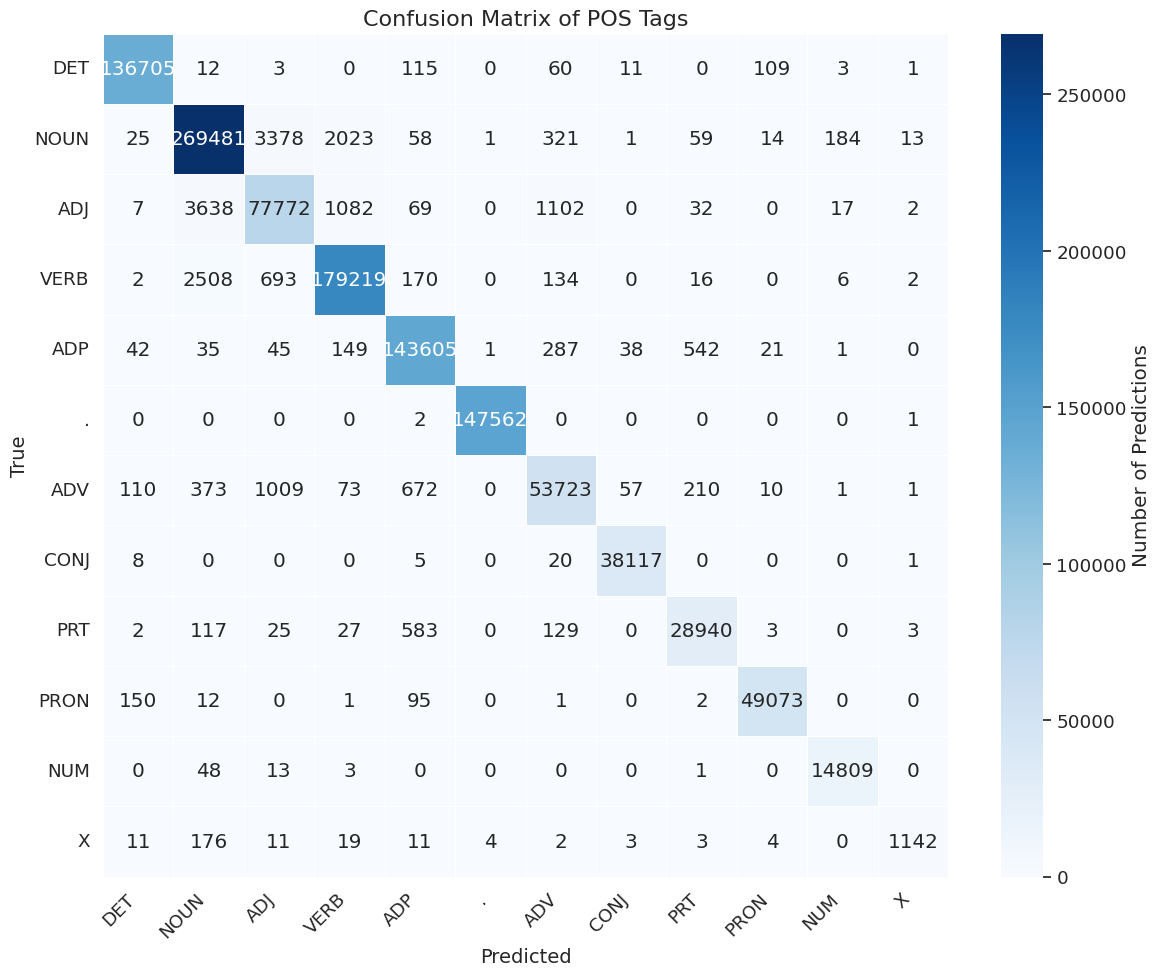

In [ ]:
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)  # Increase font scale for readability
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                      xticklabels=labels, yticklabels=labels,
                      cbar_kws={'label': 'Number of Predictions'},
                      linewidths=.5)

# Set labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix of POS Tags', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# Optional: Displaying the classification report in a more visually appealing format
report = metrics.flat_classification_report(y, y_pred_full, labels=labels, digits=3, output_dict=True)

# Convert the report to a DataFrame for better visualization
import pandas as pd

report_df = pd.DataFrame(report).transpose()

# Create a styled DataFrame for better visualization
styled_report = report_df.style.background_gradient(cmap='coolwarm')

# Display the styled report
styled_report

,precision,recall,f1-score,support
DET,0.997395,0.997708,0.997552,137019.000000
NOUN,0.974967,0.977947,0.976455,275558.000000
ADJ,0.937588,0.928943,0.933245,83721.000000
VERB,0.981506,0.980679,0.981092,182750.000000
ADP,0.987757,0.991980,0.989864,144766.000000
.,0.999959,0.999980,0.999970,147565.000000
ADV,0.963140,0.955262,0.959185,56239.000000
CONJ,0.997122,0.999109,0.998115,38151.000000
PRT,0.970978,0.970197,0.970587,29829.000000
PRON,0.996730,0.994710,0.995719,49334.000000


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_true_flat, y_pred_flat, labels=labels, average=None)

# Calculate F0.5 and F2 scores
f05_score = (1 + 0.5 * 0.5) * (precision * recall) / (0.5*0.5 * precision + recall)
f2_score = (1 + 2 * 2) * (precision * recall) / (2 * 2 * precision + recall)

# Print scores rounded to 3 decimal places
print("Overall Performance:")
print(f"Precision: {np.round(np.mean(precision), 3)}")
print(f"Recall: {np.round(np.mean(recall), 3)}")
print(f"F1-score: {np.round(np.mean(f1), 3)}")
print(f"F0.5-score: {np.round(np.mean(f05_score), 3)}")
print(f"F2-score: {np.round(np.mean(f2_score), 3)}")


Overall Performance:
Precision: 0.981
Recall: 0.968
F1-score: 0.974
F0.5-score: 0.978
F2-score: 0.97


In [ ]:
#obtaining the most likely and the least likely transitions
from collections import Counter

def print_transitions(transition_features):
    for (label_from, label_to), weight in transition_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top 10 likely transitions - \n")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop 10 unlikely transitions - \n")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top 10 likely transitions - 

X      -> X       7.295439
ADJ    -> NOUN    4.571271
NOUN   -> PRON    2.959873
NOUN   -> NOUN    2.775534
DET    -> NOUN    2.593313
PRT    -> VERB    2.330350
VERB   -> NOUN    2.274112
PRON   -> VERB    2.201400
NOUN   -> VERB    2.101517
ADV    -> ADJ     2.031451

Top 10 unlikely transitions - 

PRON   -> X       -2.282275
PRON   -> NUM     -2.297077
DET    -> ADP     -2.315015
NUM    -> DET     -2.357280
DET    -> DET     -2.561307
NUM    -> VERB    -2.598811
DET    -> CONJ    -2.929279
X      -> DET     -3.131242
CONJ   -> CONJ    -3.701822
CONJ   -> .       -4.103509


In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.1 MB/s eta 0:00:00


In [ ]:
import pickle
import sklearn_crfsuite
import gradio as gr

# Test sentence for prediction
test_sent = [('The', ''), ('quick', ''), ('brown', ''), ('fox', ''), ('jumps', ''), ('over', ''), ('the', ''), ('lazy', ''), ('dog', '')]
X_test = sent2features(test_sent)

# Save the CRF model to a pickle file after training (only needs to be done once)
def save_crf_model(crf):
    with open('crf_model.pkl', 'wb') as f:
        pickle.dump(crf, f)
    print("CRF model saved!")

# Load the CRF model from a pickle file for reuse
def load_crf_model():
    with open('crf_model.pkl', 'rb') as f:
        return pickle.load(f)

# Save model after training (run this after training the model)
save_crf_model(crf)

# Load the CRF model
crf_model_load = load_crf_model()

# Predict using the loaded CRF model
def tag_sentence(input_sentence):
    words = input_sentence.split()  # Split the sentence into words
    result = [(word, '') for word in words]  # Create a tuple for each word
    return crf_model_load.predict_single(sent2features(result))

# Gradio interface for POS tagging
interface = gr.Interface(
    fn=tag_sentence,                     # Your POS tagging function
    inputs="text",                        # Takes a text input
    outputs="json",                       # Outputs in JSON format (word, POS tag pairs)
    title="Parts of Speech Tagging Tool", # Interface title
    description="Enter a sentence to see its parts of speech tags.",
)

# Launch the interface
interface.launch(share=True)

In [ ]:
test_sent = [('The', ''), ('quick', ''), ('brown', ''), ('fox', ''), ('jumps', ''), ('over', ''), ('the', ''), ('lazy', ''), ('dog', '')]
X_test = sent2features(test_sent)
y_pred = crf.predict_single(X_test)
print(list(zip(sent2tokens(test_sent), y_pred)))

[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'NOUN'), ('fox', 'NOUN'), ('jumps', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]


# HMM Vs CRF COMPARISON

In [ ]:
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "She sells sea shells by the sea shore.",
    "A watched pot never boils.",
    "The sun sets in the west.",
    "John gave Mary a bouquet of roses.",
    "I will meet you at the park tomorrow evening.",
    "Can you help me with my homework?",
    "The book on the table belongs to Sarah.",
    "The cat chased the mouse across the garden.",
    "They are going to the movies tonight.",
    "It is raining heavily outside.",
    "The man walked his dog in the park.",
    "The cake tastes better with fresh strawberries.",
    "Please bring me a cup of coffee with sugar.",
    "The phone rang, but nobody answered.",
    "He plays the piano beautifully.",
    "The children are playing in the yard.",
    "I forgot to lock the door before leaving.",
    "The teacher gave us a lot of homework.",
    "He wants to learn how to drive a car.",
    "The plane will land in about an hour.",
    "I have never been to Paris.",
    "She enjoys reading mystery novels.",
    "We will go hiking this weekend.",
    "The concert was absolutely amazing.",
    "I would like to order a pizza.",
    "The sun rises in the east.",
    "They are building a new bridge over the river.",
    "I need to finish my project by tomorrow.",
    "The flowers in the garden are blooming.",
    "The baby is sleeping in the crib.",
    "We had a great time at the party last night.",
    "He can solve complex mathematical problems.",
    "The book was published last year.",
    "They are planning a trip to Japan next summer.",
    "I like to watch movies on the weekends.",
    "The car broke down on the highway.",
    "She is an excellent dancer.",
    "He always forgets to water the plants.",
    "I bought a new laptop yesterday.",
    "The sky is clear and blue today.",
    "I need to call my mom to check on her.",
    "They are discussing the new project in the meeting.",
    "The store opens at 9 AM every day.",
    "We are going to the beach this weekend.",
    "She is writing a letter to her friend.",
    "He runs five miles every morning.",
    "The train is arriving at the station.",
    "The restaurant serves delicious Italian food.",
    "I am reading a book about space exploration."
]

In [ ]:
correct_pos_tags = [
    ['DET', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'ADV', 'PUNCT'],
    ['NOUN', 'VERB', 'ADP', 'NOUN', 'ADV', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['ADV', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'ADV', 'PUNCT'],
    ['PRON', 'VERB', 'ADJ', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['ADV', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'ADV', 'PUNCT'],
    ['PRON', 'VERB', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['ADV', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'AUX', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'],
    ['PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'PUNCT']
]

In [ ]:
# This is just to keep the runtime

In [ ]:
def hmm_predict(sentence):
    # Process the sentence according to HMM input requirements (add start and end tokens)
    sentence = ['^'] + sentence.lower().split() + ['$']
    hmm_tags = Viterbi_Algorithm(sentence, Last_POS_tag_counts, Last_word_pos_tags, Last_Tag_transition_count)
    return hmm_tags[1:-1]  # Remove start (^) and end ($) tags

# For CRF
def crf_predict(sentence):
    sentence_tokenized = [(word, '') for word in sentence.split()]
    sentence_features = sent2features(sentence_tokenized)
    return crf.predict_single(sentence_features)

hmm_predictions = []
crf_predictions = []

# Loop over the 50 sentences and store the predictions for both models
for i, sentence in enumerate(sentences):
    # Get POS tags using HMM model
    hmm_pos_tags = hmm_predict(sentence)
    hmm_predictions.append(hmm_pos_tags)

    # Get POS tags using CRF model
    crf_pos_tags = crf_predict(sentence)
    crf_predictions.append(crf_pos_tags)

# Flatten the lists of predictions and correct tags to evaluate overall accuracy and recall
flat_correct_tags = [tag for sent_tags in correct_pos_tags for tag in sent_tags]
flat_hmm_predictions = [tag for pred_tags in hmm_predictions for tag in pred_tags]
flat_crf_predictions = [tag for pred_tags in crf_predictions for tag in pred_tags]

# Calculate overall accuracy
hmm_accuracy = accuracy_score(flat_correct_tags, flat_hmm_predictions)
crf_accuracy = accuracy_score(flat_correct_tags, flat_crf_predictions)

# Calculate overall recall
hmm_recall = recall_score(flat_correct_tags, flat_hmm_predictions, average='weighted', zero_division=0)
crf_recall = recall_score(flat_correct_tags, flat_crf_predictions, average='weighted', zero_division=0)

# Print overall metrics
print(f"Overall HMM Accuracy: {hmm_accuracy}")
print(f"Overall CRF Accuracy: {crf_accuracy}")
print(f"Overall HMM Recall: {hmm_recall}")
print(f"Overall CRF Recall: {crf_recall}")

NameError: name 'Last_POS_tag_counts' is not defined